# Test Drought Event Plot

a. stein 7.14.2022

Following the work developed in `explore/drought_event_tracking.ipynb`, this notebook fixes the sorting to get coloring correct when plotting the events and applies a test for the Game of Life.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

spi_intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]
cats = ['neutral_wet', 'D0', 'D1', 'D2', 'D3', 'D4']

dm_vars = ['USDM']
dm_vars.extend([f'spi_{interval}' for interval in spi_intervals])

paired_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI.nc')

In [3]:
paired_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 ...
    USDM         (index, lat, lon) float64 ...
    USDM Date    (index) datetime64[ns] ...
    spi_1y       (index, lat, lon) float32 ...
    spi_2y       (index, lat, lon) float32 ...
    spi_5y       (index, lat, lon) float32 ...
    spi_14d      (index, lat, lon) float32 ...
    spi_30d      (index, lat, lon) float32 ...
    spi_90d      (index, lat, lon) float32 ...
    spi_180d     (index, lat, lon) float32 ...
    spi_270d     (index, lat, lon) float32 ...
    SPI Date     (index) datetime64[ns] ...
Attributes:
    author:       a. stein 6/8/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

### Drought Event Encoding

The method I propose is a modification on Pfaffstetter encoding, which nicely handles diverging/bifurcating/splitting objects, but does not address joining objects since it is designed for river networks which only split one way (note that this is defined for river networks by going upstream). To address this, I propose adding a "." as a delimiter in the string to store events. The larger of the two events becomes the primary event occurring and would retain the front-most space ahead of all the "." while following it is it's history until completion. The other problem with Pfaffstetter encoding is that by relying solely on digits, it can only hold up to 9 different categories at the topmost level ... which for is great for river basins but there will likely be more then 9 independent drought events in an entire time series. To address this, I propose adding a "-" to denote a split.

Event X on at it's start, if it's start is independent, would only have code "1" ... while event Y starting at the same time would have code "2". Now, let's say that event X split into 2 events A and B, this would give us codes "1-1" for A and "1-2" for B, (although which one has a second digit of "2" is arbitrary). This allows us to identify that events A and B came from event X because their first digit is "1". Now let's say that event Y merges with event A. The combination of Y and A would produce code "2.1-1" if Y is bigger, and "1-2.2" if A is bigger. By storing the consumed event after a ".", we do not loose the history of the event and can follow it throughout. Now let's assume Y was bigger so that we get "2.1-1" for this new event we'll call M. If then a new event Z emerged, this would have code "3" ... which is then oblivious to the other events if it emerges independent of them (e.g. not from a split). Let's say we wanted to then how event X changed over time, we can then search for codes that start with "1" (since in this scenario event B still exists) and for codes that have ".1" in them, indicating that it got consumed in some other event along the way. From this search we would get the times with codes "1", "1-1", "1-2", and "2.1-1". From this we can then plot how the area changes over time through a stacked line chart that would show what percentage of total event X is then in each "1-2" and "1-1" and so forth. 

If you would like to see original testing and demonstration of this example, check out `explore/drought_event_tracking.ipynb`

### Testing with Cellular Automata

Revising

`https://www.youtube.com/watch?v=wBxwPSMOWWc`

Rules of Game of Life:
- any live cell with < 2 live neighbors dies
- any live cell with 2 or 3 live neighbors lives on
- any live cell with > 3 live neighbors dies
- any dead cell with exactly 3 live neighbors becomes a live cell

In [4]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

Test function works, this should alternate between a horizontal and vertical bar.

In [5]:
init_matrix = np.array([
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
])
init_matrix

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

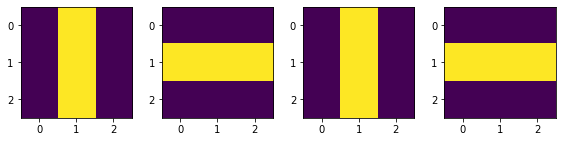

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(8,2))

plot_matrix = init_matrix

for ax in axs.ravel():

    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

plt.tight_layout()

Success. Now I can generate a test scenario

In [7]:
test_matrix = np.zeros((15,15))

for i in np.arange(test_matrix.shape[0]):
    for j in np.arange(test_matrix.shape[1]):
        test_matrix[i][j] = np.random.randint(2)

test_matrix

array([[1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.],
       [1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.],
       [1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0.],
       [1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 1.

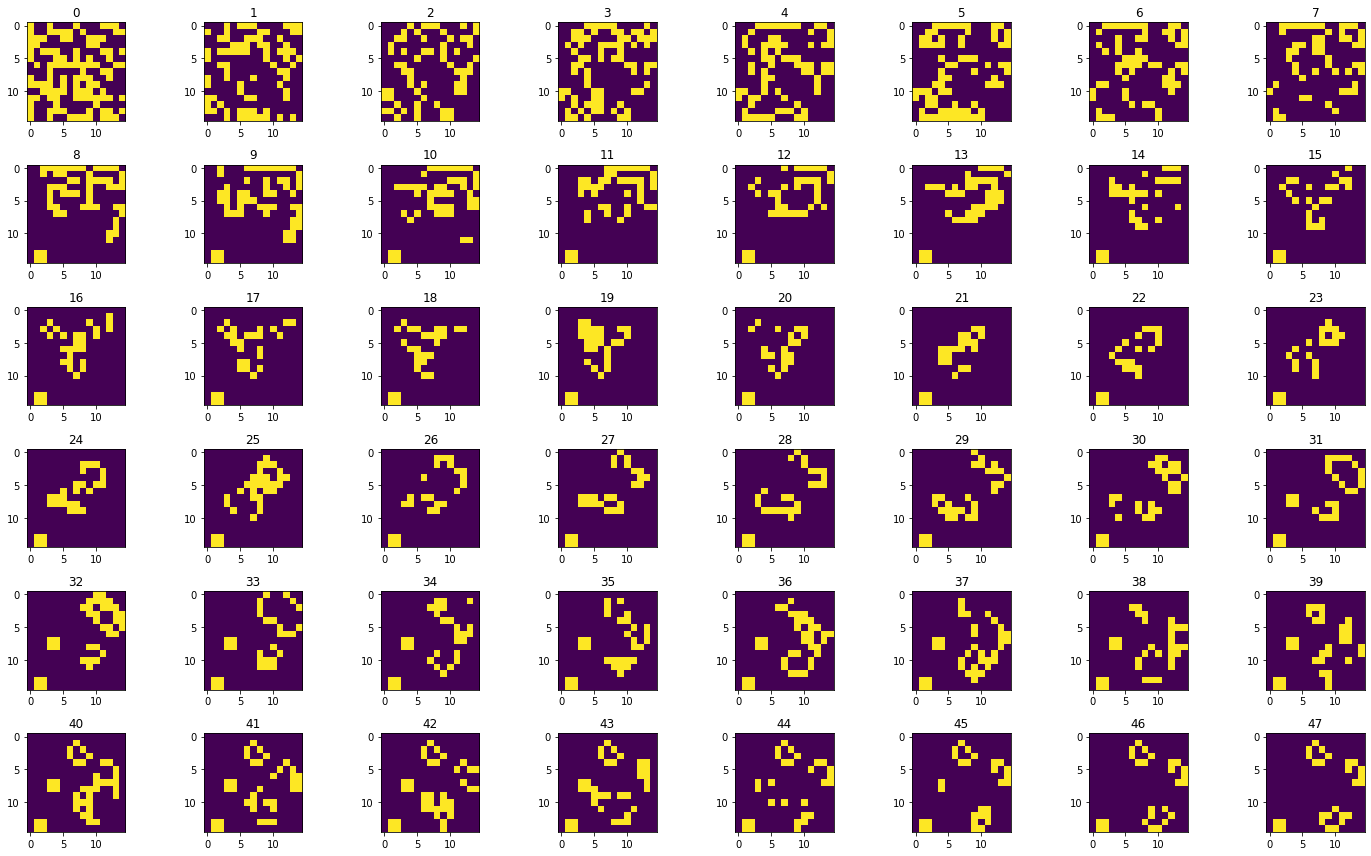

In [8]:
fig, axs = plt.subplots(6, 8, figsize=(20,12))

test_series = []
plot_matrix = test_matrix

for i, ax in enumerate(axs.ravel()):
    test_series.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

plt.tight_layout()

Beautiful

Now to apply the drought tracking

In [9]:
test_array = np.array(test_series)

test_events = wrangle.encode_drought_events(test_array)

Identifying Blobs:   0%|          | 0/48 [00:00<?, ?it/s]

Encoding Blobs:   0%|          | 0/47 [00:00<?, ?it/s]

In [10]:
test_events['frac_area'] = test_events['area']/(15*15)
test_events.head()

area  convex_area  \
time drought_id                      
0    1            102          207   
     2              5            6   
     3              1            1   
     4              1            1   
1    1-1           39           94   

                                                            coords drought_id  \
time drought_id                                                                 
0    1           [[0, 0], [0, 3], [0, 7], [1, 0], [1, 3], [1, 4...          1   
     2               [[0, 11], [0, 12], [0, 13], [1, 13], [1, 14]]          2   
     3                                                   [[4, 14]]          3   
     4                                                  [[11, 14]]          4   
1    1-1         [[0, 3], [0, 5], [0, 6], [0, 7], [1, 3], [1, 8...        1-1   

                 frac_area  
time drought_id             
0    1            0.453333  
     2            0.022222  
     3            0.004444  
     4            0.004444  
1    1-1          0.173333

In [11]:
#test_events.index.get_level_values(1)

Wow, random game of life really blows up id's

I'm going to count how many events are being spotted in each frame to double check that that's working right.

In [12]:
num_events = []
for i in np.arange(48):
    num_events.append(len(test_events.loc[i]))
num_events

[4,
 12,
 9,
 4,
 6,
 7,
 9,
 10,
 3,
 7,
 4,
 6,
 5,
 3,
 10,
 6,
 5,
 6,
 4,
 2,
 5,
 3,
 4,
 5,
 3,
 3,
 5,
 3,
 3,
 3,
 5,
 4,
 4,
 5,
 5,
 6,
 3,
 5,
 6,
 8,
 4,
 7,
 6,
 6,
 9,
 5,
 4,
 4]

Those look good.

<AxesSubplot:xlabel='Time', ylabel='frac_area in drought event'>

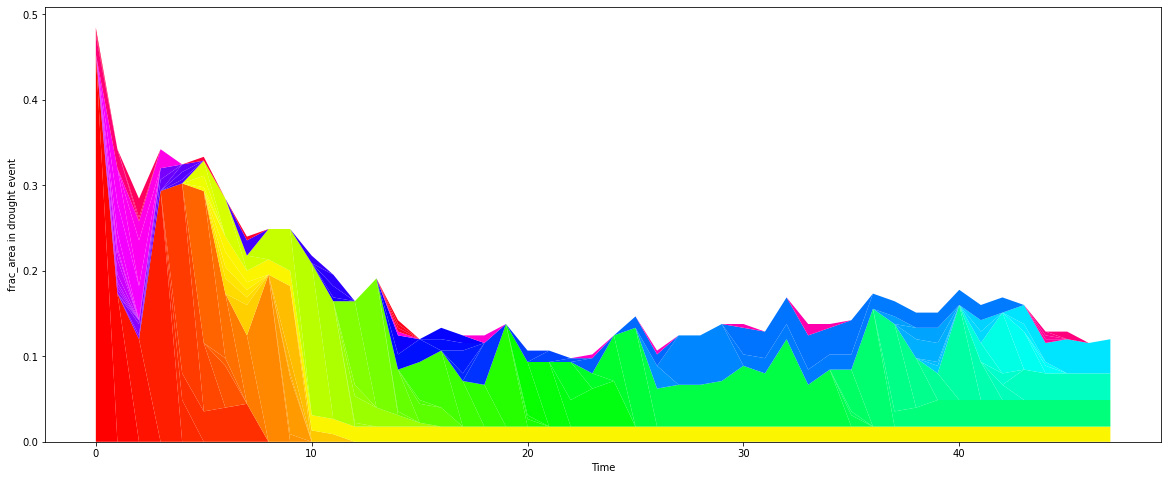

In [13]:
fig, ax = plt.subplots(figsize=(20,8))

wrangle.plot_drought_evolution(test_events, ax=ax, plot_var='frac_area', plot_legend=False, event_id='')

Fixing sorting algorithm for color-coding

In [14]:
df = test_events
event_id = ''

related_events_idx = [i for i, val in enumerate(df['drought_id']) if event_id == '' or wrangle.check_event_id_trace(event_id, val)]
thread_df = df.iloc[related_events_idx]
unique_drought_id = set(thread_df['drought_id'].values)

In [15]:
#unique_drought_id

In [16]:
sorted_id_top_splits = {id:[int(num) for num in id.split('.')[0].split('-')] for id in unique_drought_id}
#sorted_id_top_splits

In [17]:
len(unique_drought_id) == len(sorted_id_top_splits)

True

In [18]:
test_list = [1]
test_list.insert(0, 2)
test_list

[2, 1]

In [19]:
# turns out this was doing some double counting!!!

def sort_drought_ids(unique_drought_id):

    sorted_id_top_splits = {id:[int(num) for num in id.split('.')[0].split('-')] for id in unique_drought_id}

    sorted_ids = [unique_drought_id[0]]
    sorted_vals = [sorted_id_top_splits[unique_drought_id[0]]]

    for id in unique_drought_id:
        val = sorted_id_top_splits[id]

        i = 0
        id_place = i
        while i < len(sorted_ids):
            compare_id = sorted_ids[i]
            compare_val = sorted_vals[i]

            j = 0
            while j < len(val) and j < len(compare_val):
                if val[j] > compare_val[j]:
                    id_place = i+1
                j += 1

            i += 1

        sorted_ids.insert(id_place, id)
        sorted_vals.insert(id_place, val)

    return sorted_ids, sorted_vals

In [20]:
def plot_drought_evolution(df:pd.DataFrame, event_id='', plot_var='area', ax=None, plot_legend=True, cmap=plt.cm.get_cmap('hsv')):
    """Plots the evolution of droughts over time from blob detection.

    Parameters
    ----------
    df : pd.DataFrame
        Expected to be the output of encode_drought_events
    event_id : str (optional)
        The initial drought_id of the drought wishing to follow.
        Defaults as '' to plot everything.
    plot_var : str (optional)
        Variable from df to plot, defaults as 'area' to plot pixel
        area computed from blob detection.
    ax (optional)
        matplotlib axes object to plot on. one will be created
        if not given.
    plot_legend : boolean
        Whether to plot the legend (which can sometimes be quite long).
        Defaults as True to plot the legend
    """

    assert(isinstance(event_id, str))

    if ax is None:
        __, ax = plt.subplots()

    related_events_idx = [i for i, val in enumerate(df['drought_id']) if event_id == '' or wrangle.check_event_id_trace(event_id, val)]
    thread_df = df.iloc[related_events_idx]

    # need to grab the last value since we aren't going to get a df to plot
    # from times when there is no drought
    times = np.arange(df.index.get_level_values(0)[-1]+1)
    template = np.zeros(len(times))

    unique_drought_id = sort_drought_ids(list(set(thread_df['drought_id'].values)))[0]
    #print(unique_drought_id)

    droughts = []
    for id in unique_drought_id:
        event_df = thread_df[thread_df.drought_id == id]
        event_array = template.copy()
        event_times = event_df.index.get_level_values(0)

        for time in event_times:
            event_array[time] = event_df.loc[time][plot_var]
        
        droughts.append(event_array)

    color_array = np.linspace(0, 1, len(droughts))
    colors = cmap(color_array)

    ax.stackplot(times, *droughts, labels=unique_drought_id, colors=colors)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{plot_var} in drought event')

    if plot_legend:
        ax.legend()

    return ax

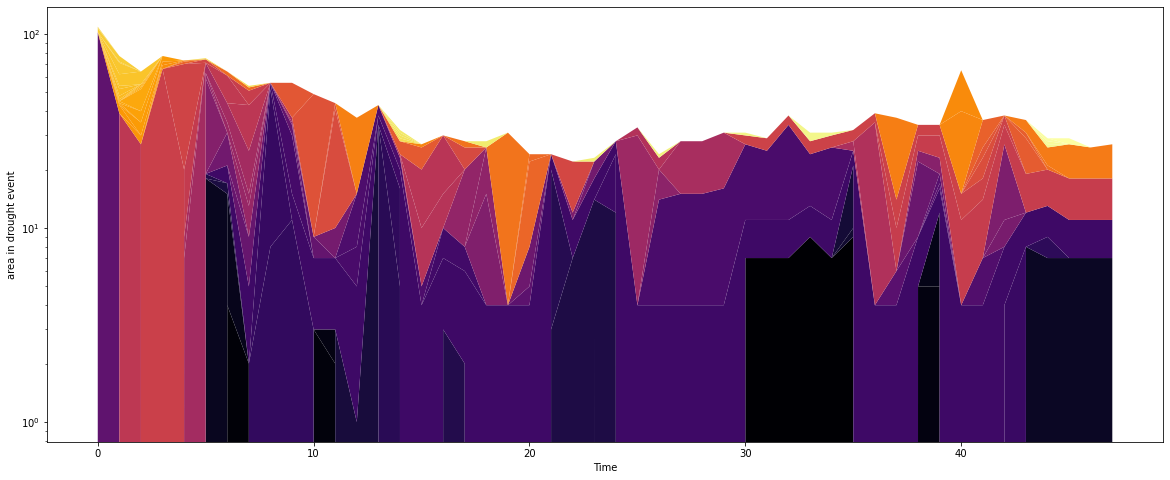

In [21]:
fig, ax = plt.subplots(figsize=(20,8))

plot_drought_evolution(test_events, ax=ax, plot_var='area', plot_legend=False, event_id='', cmap=mpl.cm.get_cmap('inferno'))
ax.set_yscale('log')

I think that sorting works?

### Analysis of USDM & SPI

In [22]:
USDM_events = wrangle.encode_drought_events(paired_ds['USDM'].values)

Identifying Blobs:   0%|          | 0/1148 [00:00<?, ?it/s]

Encoding Blobs:   0%|          | 0/1147 [00:00<?, ?it/s]

In [23]:
USDM_events['frac_area'] = USDM_events['area']/(84*188)
USDM_events

area  convex_area  \
time drought_id                                         
56   1                               653          665   
57   1                               653          665   
58   1                             12006        13514   
     2                                37           65   
     3                                 1            1   
...                                  ...          ...   
1144 75.(76).(77.(78))-1.(80)-1-2      2            2   
1145 75.(76).(77.(78))-1.(80)-1-1   6861         7561   
     75.(76).(77.(78))-1.(80)-1-2      2            2   
1146 75.(76).(77.(78))-1.(80)-1-1   6771         7276   
1147 75.(76).(77.(78))-1.(80)-1-1   6810         7316   

                                                                              coords  \
time drought_id                                                                        
56   1                             [[0, 154], [0, 155], [0, 156], [0, 157], [0, 1...   
57   1                             [[0, 154], [0, 155], [0, 156], [0, 157], [0, 1...   
58   1                             [[0, 49], [0, 50], [0, 51], [0, 52], [0, 53], ...   
     2                             [[6, 41], [7, 41], [7, 43], [7, 44], [7, 45], ...   
     3                                                                    [[10, 53]]   
...                                                                              ...   
1144 75.(76).(77.(78))-1.(80)-1-2                               [[82, 62], [82, 63]]   
1145 75.(76).(77.(78))-1.(80)-1-1  [[0, 113], [0, 114], [0, 115], [0, 116], [0, 1...   
     75.(76).(77.(78))-1.(80)-1-2                               [[82, 62], [82, 63]]   
1146 75.(76).(77.(78))-1.(80)-1-1  [[0, 114], [0, 115], [0, 116], [0, 117], [0, 1...   
1147 75.(76).(77.(78))-1.(80)-1-1  [[0, 113], [0, 114], [0, 115], [0, 116], [0, 1...   

                                                     drought_id  frac_area  
time drought_id                                                             
56   1                                                        1   0.041350  
57   1                                                        1   0.041350  
58   1                                                        1   0.760258  
     2                                                        2   0.002343  
     3                                                        3   0.000063  
...                                                         ...        ...  
1144 75.(76).(77.(78))-1.(80)-1-2  75.(76).(77.(78))-1.(80)-1-2   0.000127  
1145 75.(76).(77.(78))-1.(80)-1-1  75.(76).(77.(78))-1.(80)-1-1   0.434460  
     75.(76).(77.(78))-1.(80)-1-2  75.(76).(77.(78))-1.(80)-1-2   0.000127  
1146 75.(76).(77.(78))-1.(80)-1-1  75.(76).(77.(78))-1.(80)-1-1   0.428761  
1147 75.(76).(77.(78))-1.(80)-1-1  75.(76).(77.(78))-1.(80)-1-1   0.431231  

[1408 rows x 5 columns]

In [24]:
len(set(USDM_events['drought_id'].values))

151

<AxesSubplot:xlabel='Time', ylabel='frac_area in drought event'>

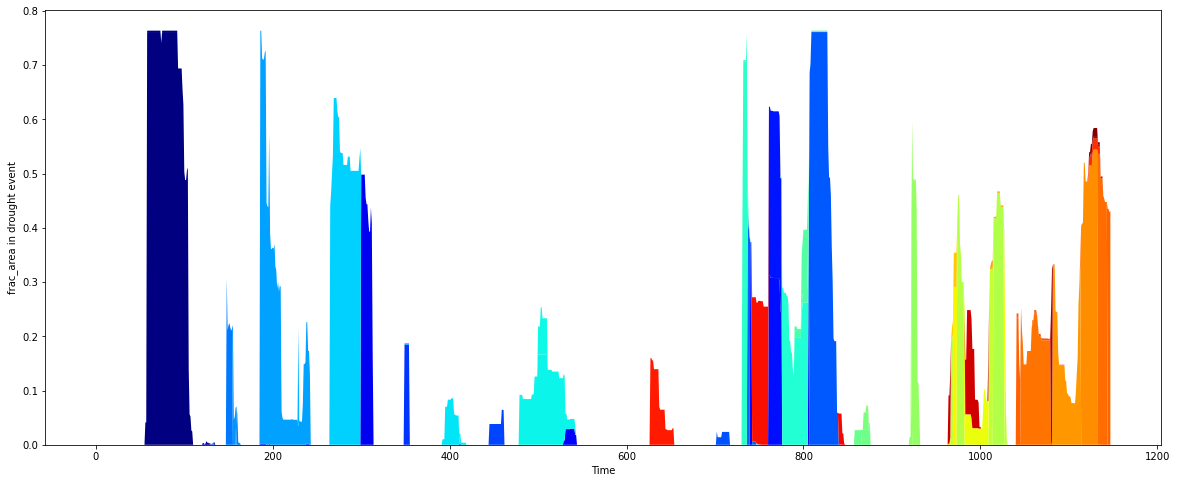

In [25]:
fig, ax = plt.subplots(figsize=(20, 8))

#wrangle.plot_drought_evolution(USDM_events, plot_legend=False, ax=ax, plot_var='frac_area', cmap=plt.cm.get_cmap('tab20c'))
plot_drought_evolution(USDM_events, plot_legend=False, ax=ax, plot_var='frac_area', cmap=plt.cm.get_cmap('jet'))

okay, the color coding is not working there how I'd hope

In [26]:
df = USDM_events
event_id = ''

related_events_idx = [i for i, val in enumerate(df['drought_id']) if event_id == '' or wrangle.check_event_id_trace(event_id, val)]
thread_df = df.iloc[related_events_idx]
unique_drought_id = list(set(thread_df['drought_id'].values))

In [27]:
sorted_ids, sorted_vals = sort_drought_ids(list(unique_drought_id))

In [28]:
sorted_id_top_splits = {id:[int(num) for num in id.split('.')[0].split('-')] for id in unique_drought_id}

sorted_ids = [unique_drought_id[0]]
sorted_vals = [sorted_id_top_splits[unique_drought_id[0]]]

for id in unique_drought_id:
    val = sorted_id_top_splits[id]

    i = 0
    id_place = i
    while i < len(sorted_ids):
        compare_id = sorted_ids[i]
        compare_val = sorted_vals[i]

        j = 0
        while j < len(val) and j < len(compare_val):
            if val[j] > compare_val[j]:
                id_place = i+1
            j += 1

        i += 1

    sorted_ids.insert(id_place, id)
    sorted_vals.insert(id_place, val)

In [29]:
first_layers = dict()

for id in unique_drought_id:
    val = sorted_id_top_splits[id]

    if val[0] not in first_layers.keys():
        first_layers[val[0]] = []
    
    first_layers[val[0]].append(id)

In [30]:
first_layers

{36: ['36-1.(36-2)-1.(36-1.(36-2)-3-2)',
  '36-1.(36-2)',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42)',
  '36-1.(36-2)-2',
  '36-2',
  '36-1',
  '36-1.(36-2)-3',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)',
  '36',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-3',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40)',
  '36-1.(36-2)-3-2',
  '36-1.(36-2)-3-1',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-1',
  '36-1.(36-2)-1',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-2'],
 60: ['60.(62).(61).(65.(66).(63))-1',
  '60.(62).(61)',
  '60.(62).(61).(65.(66).(63))-1-1.(69).(74).(73)-1-3',
  '60.(62).(61).(65.(66).(63))-1-1',
  '60.(62).(61).(65.(66).(63))-1-1.(69).(74).(73)-1',
  '60.(62).(61).(65.(66).(63))-2',
  '60.(62).(61).(65.(66).(63))-1-1.(69).(74).(73)-3',
  '60.(62).(61).(65.(66).(63))-1-1.(69).(74).(73)-2',
  '60.(62).(61).(65.(66).(63))-1-1.(69).(74).(73)-1-2',
  '60.(62).(61).(65.(66).(63))-3',
  '60.(62).(61).(65.(66).(63))-1-1.(69)',
  '60.(62)',
  '60.(62).(61).(6

In [31]:
len(unique_drought_id)

151

In [32]:
len(np.hstack(list(first_layers.values())))

151

In [33]:
def sort_at_index(ids, index):

    top_vals = {id:[int(num) for num in id.split('.')[0].split('-')] for id in ids}

    index_collected = dict()

    for id in ids:
        vals = top_vals[id]
        if len(vals) > index:
            index_val = vals[index]
            if index_val not in index_collected.keys():
                index_collected[index_val] = []
            index_collected[index_val].append(id)
    
    return index_collected


In [34]:
first_layers = sort_at_index(unique_drought_id, 0)
first_layers

{36: ['36-1.(36-2)-1.(36-1.(36-2)-3-2)',
  '36-1.(36-2)',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42)',
  '36-1.(36-2)-2',
  '36-2',
  '36-1',
  '36-1.(36-2)-3',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)',
  '36',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-3',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40)',
  '36-1.(36-2)-3-2',
  '36-1.(36-2)-3-1',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-1',
  '36-1.(36-2)-1',
  '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-2'],
 60: ['60.(62).(61).(65.(66).(63))-1',
  '60.(62).(61)',
  '60.(62).(61).(65.(66).(63))-1-1.(69).(74).(73)-1-3',
  '60.(62).(61).(65.(66).(63))-1-1',
  '60.(62).(61).(65.(66).(63))-1-1.(69).(74).(73)-1',
  '60.(62).(61).(65.(66).(63))-2',
  '60.(62).(61).(65.(66).(63))-1-1.(69).(74).(73)-3',
  '60.(62).(61).(65.(66).(63))-1-1.(69).(74).(73)-2',
  '60.(62).(61).(65.(66).(63))-1-1.(69).(74).(73)-1-2',
  '60.(62).(61).(65.(66).(63))-3',
  '60.(62).(61).(65.(66).(63))-1-1.(69)',
  '60.(62)',
  '60.(62).(61).(6

Cool, didn't loose any

In [35]:
layers = first_layers.copy()

for key_val in first_layers.keys():
    group = first_layers[key_val]
    if len(group) > 1:
        layers[key_val] = sorted(sort_at_index(group, 1).items())

In [36]:
layers

{36: [(1,
   ['36-1.(36-2)-1.(36-1.(36-2)-3-2)',
    '36-1.(36-2)',
    '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42)',
    '36-1.(36-2)-2',
    '36-1',
    '36-1.(36-2)-3',
    '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)',
    '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-3',
    '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40)',
    '36-1.(36-2)-3-2',
    '36-1.(36-2)-3-1',
    '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-1',
    '36-1.(36-2)-1',
    '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-2']),
  (2, ['36-2'])],
 60: [],
 67: ['67'],
 83: ['83'],
 22: ['22'],
 57: ['57'],
 7: ['7'],
 14: ['14'],
 50: ['50'],
 75: [],
 2: ['2'],
 39: ['39'],
 23: [(1, ['23-1']), (2, ['23-2'])],
 6: [],
 56: [],
 72: ['72'],
 81: ['81'],
 66: ['66'],
 64: ['64'],
 46: ['46'],
 73: ['73'],
 77: [],
 33: ['33'],
 55: ['55'],
 24: ['24'],
 48: ['48'],
 13: ['13'],
 8: [(1, ['8-1-2', '8-1', '8-1-1', '8-1-1-1', '8-1-1-2']), (2, ['8-2'])],
 44: ['44'],
 61: ['61'],
 29: ['29'],
 16: ['16'],
 43: ['43'],


In [37]:
sorted(layers.items())

[(1, ['1']),
 (2, ['2']),
 (3, ['3']),
 (4, ['4']),
 (5, [(1, ['5-1', '5-1.(5-2)-1', '5-1.(5-2)-2', '5-1.(5-2)']), (2, ['5-2'])]),
 (6, []),
 (7, ['7']),
 (8, [(1, ['8-1-2', '8-1', '8-1-1', '8-1-1-1', '8-1-1-2']), (2, ['8-2'])]),
 (9, ['9']),
 (10, ['10']),
 (11, ['11']),
 (12, ['12']),
 (13, ['13']),
 (14, ['14']),
 (15, ['15']),
 (16, ['16']),
 (17, ['17']),
 (18, ['18']),
 (19, ['19']),
 (20, ['20']),
 (21, ['21']),
 (22, ['22']),
 (23, [(1, ['23-1']), (2, ['23-2'])]),
 (24, ['24']),
 (25, ['25']),
 (26, ['26']),
 (27, ['27']),
 (28, [(1, ['28-1']), (2, ['28-2'])]),
 (29, ['29']),
 (30, ['30']),
 (31, ['31']),
 (32, ['32']),
 (33, ['33']),
 (34, ['34']),
 (35, ['35']),
 (36,
  [(1,
    ['36-1.(36-2)-1.(36-1.(36-2)-3-2)',
     '36-1.(36-2)',
     '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42)',
     '36-1.(36-2)-2',
     '36-1',
     '36-1.(36-2)-3',
     '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)',
     '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-3',
     '36-1.(36-2)-1.(36-1.(

Given just accessing keys & values doesn't retain sorting ... thinking this might not be the best method. For sorting.

In [38]:
sorted_ids

['1',
 '2',
 '3',
 '4',
 '5-1.(5-2)',
 '5-1.(5-2)-2',
 '5-1.(5-2)-1',
 '5-1',
 '5',
 '6.(7)',
 '7',
 '8-1-2',
 '13',
 '14',
 '22',
 '23-1',
 '24',
 '33',
 '36-1.(36-2)-2',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42)',
 '36-1.(36-2)',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2)',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2)',
 '8-2',
 '11',
 '16',
 '21',
 '25',
 '28-1',
 '29',
 '32',
 '35',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)',
 '36-1.(36-2)-3',
 '36-1',
 '5-2',
 '6',
 '8',
 '8-1-1-1',
 '8-1-1-2',
 '8-1-1',
 '8-1',
 '9',
 '10',
 '12',
 '15',
 '17',
 '18',
 '19',
 '20',
 '23',
 '26',
 '27',
 '28',
 '28-2',
 '30',
 '31',
 '36-1.(36-2)-3-1',
 '36-1.(36-2)-3-2',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40)',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-3',
 '36',
 '36-2',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '46',
 '47',
 '47.(48)',
 '48',
 '50',
 '52',
 '53',
 '54',
 '55',
 '56.(55)',
 '56',
 '57',
 '58',
 '59',
 '60.(62).(61).(65.(66).(63))-1-1.(69).(74).(73)',
 '60.(62).(61).(6

In [39]:
true_sorted_ids = []
top_vals = {id:[int(num) for num in id.split('.')[0].split('-')] for id in sorted_ids}


found = True
i = 1

while found:
    found = False
    ids_found = []
    for id in sorted_ids:
        
        if i == top_vals[id][0]:
            found = True
            ids_found.append(id)
    if len(ids_found) > 1:
        sub_sorted = []
        j = 1
        while len(sub_sorted) < len(ids_found):
            for found_id in ids_found:
                vals = top_vals[found_id]
                if len(vals) > 1:
                    if j == vals[1]:
                        sub_sorted.append(found_id)
                else:
                    sub_sorted.append(found_id)
            j += 1

        ids_found = sub_sorted

    true_sorted_ids.extend(ids_found)

    i += 1

true_sorted_ids

['1',
 '2',
 '3',
 '4',
 '5-1.(5-2)',
 '5-1.(5-2)-2',
 '5-1.(5-2)-1',
 '5-1',
 '5',
 '5',
 '5-2',
 '6.(7)',
 '6',
 '7',
 '8-1-2',
 '8',
 '8-1-1-1',
 '8-1-1-2',
 '8-1-1',
 '8-1',
 '8-2',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23-1',
 '23',
 '23',
 '23-2',
 '24',
 '25',
 '26',
 '27',
 '28-1',
 '28',
 '28',
 '28-2',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36-1.(36-2)-2',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42)',
 '36-1.(36-2)',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2)',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2)',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)',
 '36-1.(36-2)-3',
 '36-1',
 '36-1.(36-2)-3-1',
 '36-1.(36-2)-3-2',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40)',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-3',
 '36',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-2',
 '36-1.(36-2)-1',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-1',
 '36',
 '36-2',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '4

In [40]:
len(sorted_ids)

152

In [41]:
len(true_sorted_ids)

158

In [42]:
import collections
collections.Counter(sorted_ids)

Counter({'1': 1,
         '2': 1,
         '3': 1,
         '4': 1,
         '5-1.(5-2)': 1,
         '5-1.(5-2)-2': 1,
         '5-1.(5-2)-1': 1,
         '5-1': 1,
         '5': 1,
         '6.(7)': 1,
         '7': 1,
         '8-1-2': 1,
         '13': 1,
         '14': 1,
         '22': 1,
         '23-1': 1,
         '24': 1,
         '33': 1,
         '36-1.(36-2)-2': 1,
         '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42)': 1,
         '36-1.(36-2)': 1,
         '36-1.(36-2)-1.(36-1.(36-2)-3-2)': 2,
         '8-2': 1,
         '11': 1,
         '16': 1,
         '21': 1,
         '25': 1,
         '28-1': 1,
         '29': 1,
         '32': 1,
         '35': 1,
         '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)': 1,
         '36-1.(36-2)-3': 1,
         '36-1': 1,
         '5-2': 1,
         '6': 1,
         '8': 1,
         '8-1-1-1': 1,
         '8-1-1-2': 1,
         '8-1-1': 1,
         '8-1': 1,
         '9': 1,
         '10': 1,
         '12': 1,
         '15': 1,
  

In [43]:
sorted_ids_copy = sorted_ids.copy()
top_ids = [id.split('.')[0] for id in sorted_ids_copy]

true_sorted_ids = []

vals = [1]
id_found = True

def vals_to_str(vals):
    return "-".join([str(val) for val in vals])

while len(vals) > 0:
    id = vals_to_str(vals)
    #print(id)
    if id in sorted_ids_copy:
        found_idx = np.where(np.array(top_ids) == id)[0]
        for idx in found_idx:
            true_sorted_ids.append(sorted_ids_copy[idx])
        #for idx in found_idx:
        #    top_ids.pop(idx)
        #    sorted_ids_copy.pop(idx)
        vals.append(1)
        id_found = True
    elif id_found:
        vals[-1] += 1 
        id_found = False     
    else:
        vals = vals[:-1]
        if len(vals) > 0:
            vals[-1] += 1

print(f'{100*len(true_sorted_ids)/len(sorted_ids):.2f}%')
true_sorted_ids

100.00%


['1',
 '2',
 '3',
 '4',
 '5',
 '5-1.(5-2)',
 '5-1.(5-2)-2',
 '5-1.(5-2)-1',
 '5-1',
 '5-2',
 '6.(7)',
 '6',
 '7',
 '8',
 '8-1',
 '8-1-1',
 '8-1-1-1',
 '8-1-1-2',
 '8-1-2',
 '8-2',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '23-1',
 '23-2',
 '24',
 '25',
 '26',
 '27',
 '28',
 '28-1',
 '28-2',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '36-1.(36-2)-2',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42)',
 '36-1.(36-2)',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2)',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2)',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)',
 '36-1.(36-2)-3',
 '36-1',
 '36-1.(36-2)-3-1',
 '36-1.(36-2)-3-2',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40)',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-3',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-2',
 '36-1.(36-2)-1',
 '36-1.(36-2)-1.(36-1.(36-2)-3-2).(40).(42).(41)-1',
 '36-2',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '47.(48)',
 '4

In [44]:
for id in sorted_ids:
    if not id in true_sorted_ids:
        print(id)

FINALLY

In [65]:
def sort_ids(ids):
    top_ids = [id.split('.')[0] for id in ids]

    true_sorted_ids = []

    vals = [1]
    id_found = True

    def vals_to_str(vals):
        return "-".join([str(val) for val in vals])

    while len(vals) > 0:
        id = vals_to_str(vals)
        if id in top_ids:
            found_idx = np.where(np.array(top_ids) == id)[0]
            
            for idx in found_idx:
                true_sorted_ids.append(ids[idx])

            vals.append(1)
            id_found = True
        elif id_found:
            vals[-1] += 1 
            id_found = False     
        else:
            vals = vals[:-1]
            if len(vals) > 0:
                vals[-1] += 1

    return true_sorted_ids

In [46]:
sort_ids(sorted_ids) == true_sorted_ids

True

In [47]:
def plot_drought_evolution(df:pd.DataFrame, event_id='', plot_var='area', ax=None, plot_legend=True, cmap=plt.cm.get_cmap('hsv')):
    """Plots the evolution of droughts over time from blob detection.

    Parameters
    ----------
    df : pd.DataFrame
        Expected to be the output of encode_drought_events
    event_id : str (optional)
        The initial drought_id of the drought wishing to follow.
        Defaults as '' to plot everything.
    plot_var : str (optional)
        Variable from df to plot, defaults as 'area' to plot pixel
        area computed from blob detection.
    ax (optional)
        matplotlib axes object to plot on. one will be created
        if not given.
    plot_legend : boolean
        Whether to plot the legend (which can sometimes be quite long).
        Defaults as True to plot the legend
    """

    assert(isinstance(event_id, str))

    if ax is None:
        __, ax = plt.subplots()

    related_events_idx = [i for i, val in enumerate(df['drought_id']) if event_id == '' or wrangle.check_event_id_trace(event_id, val)]
    thread_df = df.iloc[related_events_idx]

    # need to grab the last value since we aren't going to get a df to plot
    # from times when there is no drought
    times = np.arange(df.index.get_level_values(0)[-1]+1)
    template = np.zeros(len(times))

    unique_drought_id = sort_ids(list(set(thread_df['drought_id'].values)))
    print(len(unique_drought_id))

    droughts = []
    for id in unique_drought_id:
        event_df = thread_df[thread_df.drought_id == id]
        event_array = template.copy()
        event_times = event_df.index.get_level_values(0)

        for time in event_times:
            event_array[time] = event_df.loc[time][plot_var]
        
        droughts.append(event_array)

    color_array = np.linspace(0, 1, len(droughts))
    colors = cmap(color_array)

    ax.stackplot(times, *droughts, labels=unique_drought_id, colors=colors)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{plot_var} in drought event')

    if plot_legend:
        ax.legend()

    return ax

151


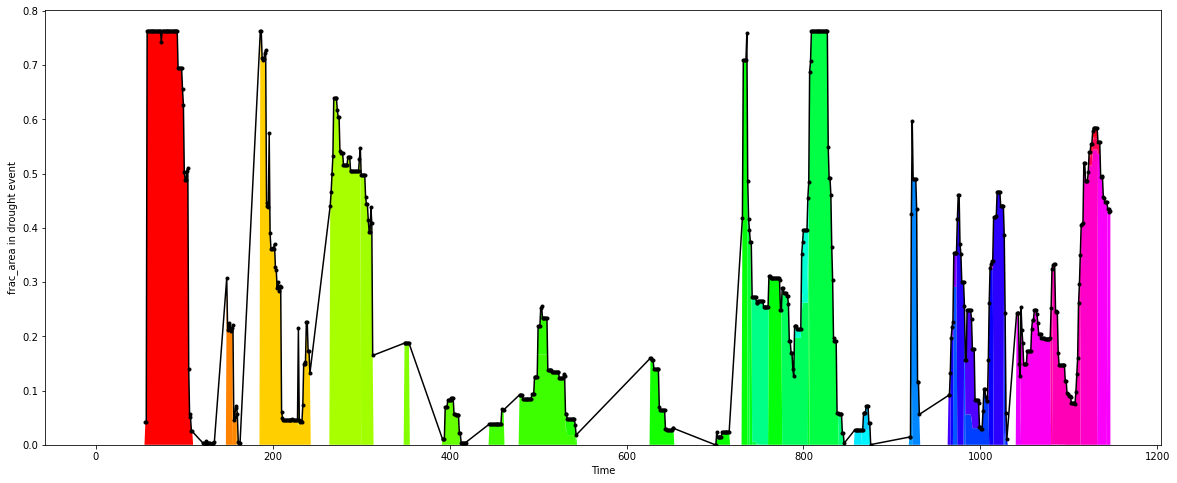

In [67]:
fig, ax = plt.subplots(figsize=(20,8))

plot_drought_evolution(USDM_events, ax=ax, plot_var='frac_area', plot_legend=False)
# plotting this to make sure didn't drop anything
ax.plot(USDM_events.groupby('time').sum()['frac_area'], color='k', marker='.')

That looks good ...

Let's double check that the test case works

144


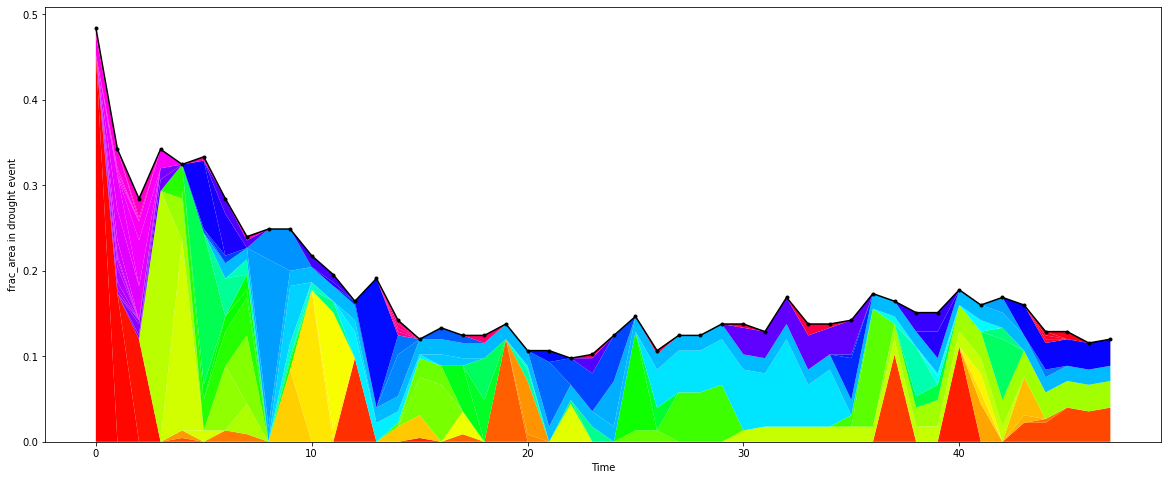

In [69]:
fig, ax = plt.subplots(figsize=(20,8))

plot_drought_evolution(test_events, ax=ax, plot_var='frac_area', plot_legend=False)
# plotting this to make sure didn't drop anything
ax.plot(test_events.groupby('time').sum()['frac_area'], color='k', marker='.')

Huh, I want to check that coloring

144


<AxesSubplot:xlabel='Time', ylabel='frac_area in drought event'>

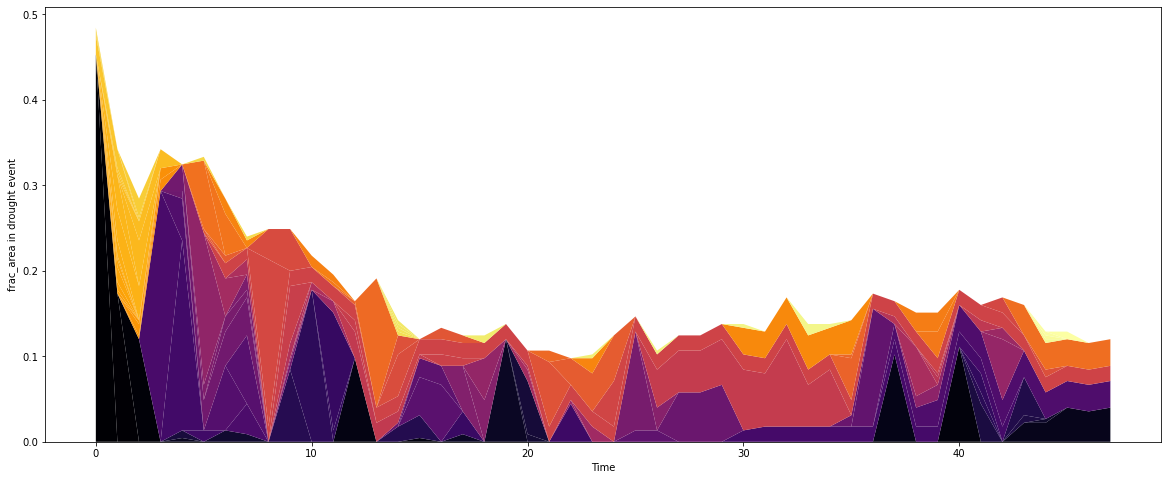

In [71]:
fig, ax = plt.subplots(figsize=(20,8))

plot_drought_evolution(test_events, ax=ax, plot_var='frac_area', plot_legend=False, cmap=plt.cm.get_cmap('inferno'))

Okay, so this would mean that the closer in color they are, the closer they are in number assigned ... or from same branch. All the dark at the bottom would mean that they all seem to originate from one of the first ones, where as the specks of lighter blips are new droughts that appear ... can I see that in the timeseries?

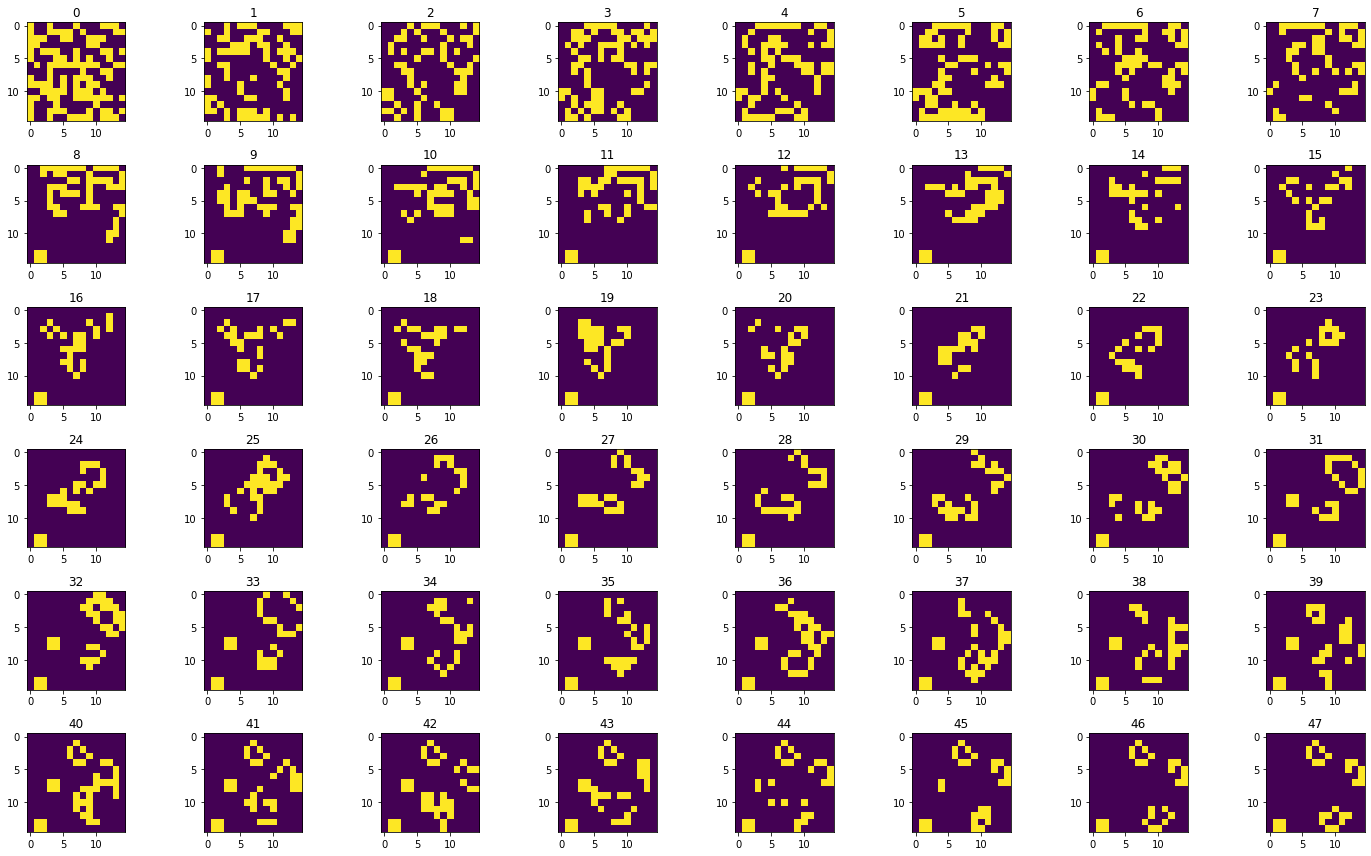

In [72]:
fig, axs = plt.subplots(6, 8, figsize=(20,12))


for i, ax in enumerate(axs.ravel()):
    ax.imshow(test_series[i])
    ax.set_title(i)

plt.tight_layout()

Yeah, it looks like the reoccurring thing event is from being carried by pixels in the top right being almost always on, and therefore "flaring" up on occasion when it happens to populate more in that area.

Okay, last thing I want to check right now is a much simpler cellular automata example and do the codes by hand to test that it's working right.

### Checking codes by hand

In [75]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
test_matrix = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

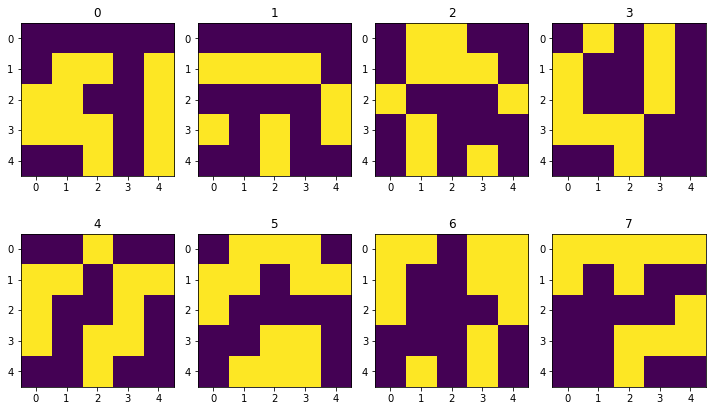

In [79]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

test_series = []
plot_matrix = test_matrix

for i, ax in enumerate(axs.ravel()):
    test_series.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

plt.tight_layout()

So I did the codes by hand on white board and they're annoyingly long yet again. Let's see what the computer gets since splits and merges are arbitrary anywho.

In [81]:
test_events = wrangle.encode_drought_events(np.array(test_series))

Identifying Blobs:   0%|          | 0/8 [00:00<?, ?it/s]

Encoding Blobs:   0%|          | 0/7 [00:00<?, ?it/s]

In [85]:
test_events['drought_id']

time  drought_id                             
0     1                                                                                1
      2                                                                                2
1     1-1.(2)                                                                    1-1.(2)
      1-2                                                                            1-2
      1-3                                                                            1-3
2     1-1.(2)                                                                    1-1.(2)
      3                                                                                3
3     1-1.(2)                                                                    1-1.(2)
4     1-1.(2)                                                                    1-1.(2)
5     1-1.(2)-1                                                                1-1.(2)-1
      1-1.(2)-2                                                 